In [6]:
# Cell 1: Imports & configuration
import os
import time
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
from pprint import pprint

# sklearn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optionals
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

try:
    import lightgbm as lgb
    has_lgb = True
except Exception:
    has_lgb = False

import joblib
import matplotlib.pyplot as plt

# tqdm for progress bars
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [9]:
import pandas as pd
from pathlib import Path

# Locate dataset
possible_paths = [
    Path("../data/raw/loan.csv"),
    Path("../data/processed/loan_cleaned_for_model.csv"),
    Path("loan_cleaned_for_model.csv"),
]

DATA_PATH = next((p for p in possible_paths if p.exists()), None)

if DATA_PATH is None:
    raise FileNotFoundError("Dataset not found.")

print("Loading from:", DATA_PATH)

# =========================
# MEMORY-SAFE CHUNK LOADING
# =========================
CHUNK_SIZE = 100_000
MAX_ROWS = 300_000

chunks = []
rows_loaded = 0

for chunk in pd.read_csv(
    DATA_PATH,
    chunksize=CHUNK_SIZE,
    low_memory=False
):
    chunks.append(chunk)
    rows_loaded += len(chunk)
    if rows_loaded >= MAX_ROWS:
        break

df = pd.concat(chunks, ignore_index=True)

print("Loaded dataset shape:", df.shape)
df.head()


Loading from: ..\data\raw\loan.csv
Loaded dataset shape: (300000, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Cell 3 (Corrected): Create binary target from loan_status + train/test split

# Inspect unique values
print("Unique loan_status values:")
print(df["loan_status"].unique())

# Define bad loan statuses
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)",
    "Does not meet the credit policy. Status:Charged Off",
    "Does not meet the credit policy. Status:Default"
]

# Create target column:
# 1 = bad loan
# 0 = good loan
df["target"] = df["loan_status"].apply(lambda x: 1 if x in bad_status else 0)

print("\nNew target distribution:")
print(df["target"].value_counts())
print((df["target"].value_counts(normalize=True) * 100).round(3))

# Drop the original loan_status?
# Yes – after encoding target, we do not want to leak future info.
df = df.drop(columns=["loan_status"])

# Prepare X, y
X = df.drop(columns=["target"])
y = df["target"]

# Train/Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Unique loan_status values:
['Current' 'Fully Paid' 'Late (31-120 days)' 'In Grace Period'
 'Charged Off' 'Late (16-30 days)' 'Default']

New target distribution:
target
0    295397
1      4603
Name: count, dtype: int64
target
0    98.466
1     1.534
Name: proportion, dtype: float64

Train shape: (240000, 144)
Test shape: (60000, 144)


In [11]:
# Cell 4: Preprocessing pipeline
import numpy as np

# Drop columns with >95% missing and obvious non-features
missing_pct = X_train.isna().mean() * 100
cols_to_drop = list(missing_pct[missing_pct > 95].index)
cols_to_drop += ["id", "member_id", "url", "desc", "title"]
# preserve order/unique
cols_to_drop = list(dict.fromkeys(cols_to_drop))

print(f"Dropping {len(cols_to_drop)} columns (high missingness / non-features).")
X_train_clean = X_train.drop(columns=cols_to_drop, errors="ignore")
X_test_clean = X_test.drop(columns=cols_to_drop, errors="ignore")
print("Cleaned train shape:", X_train_clean.shape, "Cleaned test shape:", X_test_clean.shape)

# Identify numeric vs categorical
numeric_features = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train_clean.columns if c not in numeric_features]

print(f"Numeric features: {len(numeric_features)}; Categorical features: {len(categorical_features)}")

# Transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    sparse_threshold=0.3
)

print("Preprocessor created.")


Dropping 26 columns (high missingness / non-features).
Cleaned train shape: (240000, 118) Cleaned test shape: (60000, 118)
Numeric features: 95; Categorical features: 23
Preprocessor created.


Subsample for CV: (99999, 118)

Running CV for logistic ...


logistic CV:   0%|          | 0/3 [00:00<?, ?it/s]

logistic CV ROC AUC mean: 0.9789 std: 0.0039
Time: 15.75 sec

Running CV for random_forest ...


random_forest CV:   0%|          | 0/3 [00:00<?, ?it/s]

random_forest CV ROC AUC mean: 0.9632 std: 0.0054
Time: 8.29 sec

Running CV for xgboost ...


xgboost CV:   0%|          | 0/3 [00:00<?, ?it/s]

xgboost CV ROC AUC mean: 0.9933 std: 0.0015
Time: 11.27 sec

Fitting final logistic on full training set...
Trained in 23.8 sec
Saved pipeline_logistic.joblib

--- logistic Evaluation ---
Accuracy: 0.9813, Precision: 0.4466, Recall: 0.8990, F1: 0.5968, ROC AUC: 0.9818972402638186

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     59079
           1       0.45      0.90      0.60       921

    accuracy                           0.98     60000
   macro avg       0.72      0.94      0.79     60000
weighted avg       0.99      0.98      0.98     60000


Confusion matrix:
 [[58053  1026]
 [   93   828]]


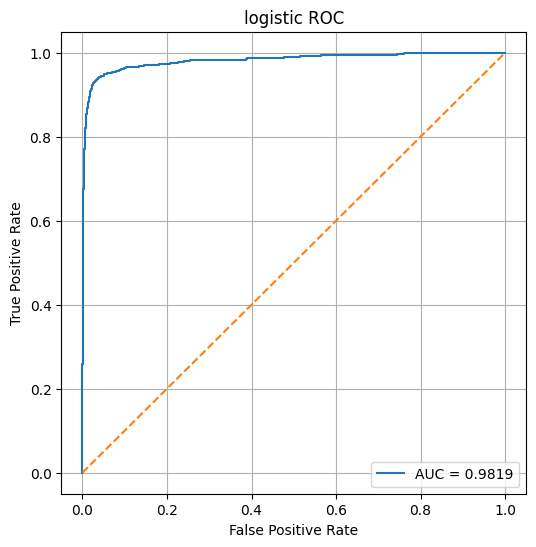


Fitting final random_forest on full training set...
Trained in 9.92 sec
Saved pipeline_random_forest.joblib

--- random_forest Evaluation ---
Accuracy: 0.9374, Precision: 0.1773, Recall: 0.8447, F1: 0.2930, ROC AUC: 0.9603440498955383

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     59079
           1       0.18      0.84      0.29       921

    accuracy                           0.94     60000
   macro avg       0.59      0.89      0.63     60000
weighted avg       0.98      0.94      0.96     60000


Confusion matrix:
 [[55468  3611]
 [  143   778]]


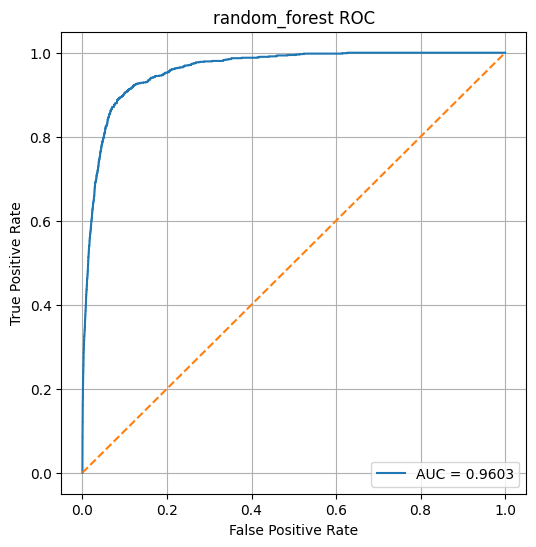


Fitting final xgboost on full training set...
Trained in 11.49 sec
Saved pipeline_xgboost.joblib

--- xgboost Evaluation ---
Accuracy: 0.9960, Precision: 0.9582, Recall: 0.7709, F1: 0.8544, ROC AUC: 0.9938379863808483

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59079
           1       0.96      0.77      0.85       921

    accuracy                           1.00     60000
   macro avg       0.98      0.89      0.93     60000
weighted avg       1.00      1.00      1.00     60000


Confusion matrix:
 [[59048    31]
 [  211   710]]


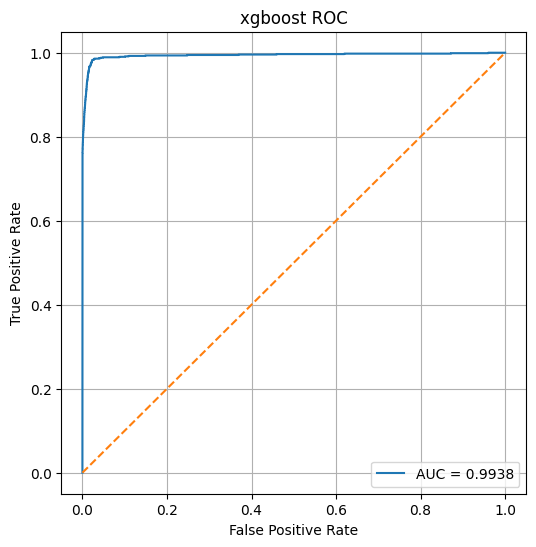


Saved model_evaluation_summary.csv


In [12]:
# Cell 5: Safe baseline CV and final training (progress bars)
# Requirements: run Cells 1-4 first.

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import time

# Config (safe defaults)
USE_SUBSAMPLE = True
SUBSAMPLE_SIZE = 100_000   # reduce on laptops if needed
N_SPLITS = 3
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 15
N_JOBS = -1

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Prepare subsample (stratified)
if USE_SUBSAMPLE:
    df_train_combined = pd.concat([X_train_clean.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    if SUBSAMPLE_SIZE >= len(df_train_combined):
        X_sub = X_train_clean
        y_sub = y_train
    else:
        subsample = df_train_combined.groupby('target', group_keys=False).apply(
            lambda x: x.sample(int(SUBSAMPLE_SIZE * len(x) / len(df_train_combined)), random_state=RANDOM_STATE)
        ).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        X_sub = subsample.drop(columns=['target'])
        y_sub = subsample['target']
    print("Subsample for CV:", X_sub.shape)
else:
    X_sub = X_train_clean
    y_sub = y_train
    print("Using full train set for CV:", X_sub.shape)

# small helper for CV with progress
def cv_with_progress(pipe, X, y, cv, desc="CV"):
    scores = []
    splits = list(cv.split(X, y))
    if tqdm is None:
        iterator = splits
    else:
        iterator = tqdm(splits, desc=desc, total=len(splits))
    for train_idx, val_idx in iterator:
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        p = clone(pipe)
        p.fit(X_tr, y_tr)
        y_proba = None
        try:
            y_proba = p.predict_proba(X_val)[:, 1]
        except Exception:
            try:
                y_proba = p.decision_function(X_val)
            except Exception:
                y_proba = None
        if y_proba is None:
            s = roc_auc_score(y_val, p.predict(X_val))
        else:
            s = roc_auc_score(y_val, y_proba)
        scores.append(s)
    return np.array(scores)

# Pipelines
models = {
    "logistic": Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "random_forest": Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(n_estimators=RF_N_ESTIMATORS, max_depth=RF_MAX_DEPTH, n_jobs=N_JOBS, class_weight="balanced", random_state=RANDOM_STATE))])
}
if has_xgb:
    models["xgboost"] = Pipeline([("pre", preprocessor), ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=8))])

cv_results = {}
for name, pipe in models.items():
    print(f"\nRunning CV for {name} ...")
    t0 = time.time()
    try:
        scores = cv_with_progress(pipe, X_sub, y_sub, cv, desc=f"{name} CV")
        print(f"{name} CV ROC AUC mean: {scores.mean():.4f} std: {scores.std():.4f}")
        cv_results[name] = scores
    except Exception as e:
        print(f"CV failed for {name}: {e}")
    finally:
        print("Time:", round(time.time() - t0, 2), "sec")

# Fit final models on full cleaned train set and evaluate on test set
final_results = {}
for name, pipe in models.items():
    print(f"\nFitting final {name} on full training set...")
    t0 = time.time()
    fitted = clone(pipe)
    fitted.fit(X_train_clean, y_train)
    print("Trained in", round(time.time() - t0, 2), "sec")
    joblib.dump(fitted, f"pipeline_{name}.joblib")
    print(f"Saved pipeline_{name}.joblib")
    # Evaluate
    y_pred = fitted.predict(X_test_clean)
    y_proba = None
    try:
        y_proba = fitted.predict_proba(X_test_clean)[:, 1]
    except Exception:
        try:
            y_proba = fitted.decision_function(X_test_clean)
        except Exception:
            y_proba = None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
    # plot ROC if probabilities available
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0,1], [0,1], "--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{name} ROC"); plt.legend(); plt.grid(True)
        plt.show()
    final_results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

pd.DataFrame(final_results).T.to_csv("model_evaluation_summary.csv")
print("\nSaved model_evaluation_summary.csv")


In [ ]:
# Cell 7: Notes & next steps
print("Notes and next steps:")
print("- If you run out of RAM, reduce SUBSAMPLE_SIZE and RF/trees or use LightGBM.")
print("- Consider using sparse output or LightGBM for full-data training.")
print("- For deployment, serialize preprocessor separately: joblib.dump(preprocessor, 'preprocessor.joblib').")
print("- Consider calibration (CalibratedClassifierCV) if you need well-calibrated probabilities.")


In [13]:
# Cell 6: Optional hyperparameter tuning (conservative)
from sklearn.model_selection import RandomizedSearchCV

rf_pipe = models["random_forest"]
param_dist = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [8, 12, 16, None],
    "clf__min_samples_split": [2, 5, 10]
}

rs = RandomizedSearchCV(rf_pipe, param_dist, n_iter=8, scoring="roc_auc", cv=cv, n_jobs=4, random_state=RANDOM_STATE, verbose=1)
print("Starting RandomizedSearchCV (this runs on X_sub/X_train depending on how you call fit).")
# Fit on the subsample to save time:
rs.fit(X_sub, y_sub)
print("Best params:", rs.best_params_)
joblib.dump(rs.best_estimator_, "rf_best_pipeline.joblib")
print("Saved rf_best_pipeline.joblib")


Starting RandomizedSearchCV (this runs on X_sub/X_train depending on how you call fit).
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__max_depth': None}
Saved rf_best_pipeline.joblib


In [16]:
from pathlib import Path
import joblib

# Ensure models directory exists
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODELS_DIR / "rf_model.pkl"

# ✅ Save the ACTUAL trained pipeline
joblib.dump(rf_pipe, MODEL_PATH)

print("Model saved at:", MODEL_PATH.resolve())
print("File size (MB):", MODEL_PATH.stat().st_size / (1024 * 1024))


Model saved at: C:\Credit-risk-scoring\models\rf_model.pkl
File size (MB): 0.0035409927368164062


In [17]:
# FIT the Random Forest pipeline (CRITICAL STEP)

rf_pipe.fit(X_train, y_train)

print("Random Forest training completed.")


Random Forest training completed.


In [18]:
from pathlib import Path
import joblib

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODELS_DIR / "rf_model.pkl"

joblib.dump(rf_pipe, MODEL_PATH)

print("Model saved at:", MODEL_PATH.resolve())
print("File size (MB):", MODEL_PATH.stat().st_size / (1024 * 1024))


Model saved at: C:\Credit-risk-scoring\models\rf_model.pkl
File size (MB): 5.5885725021362305


In [19]:
import joblib
from pathlib import Path

FEATURES_PATH = Path("../models/feature_columns.pkl")

joblib.dump(X_train.columns.tolist(), FEATURES_PATH)

print("Saved feature columns:", len(X_train.columns))


Saved feature columns: 144
